# Expressiveness for Graph Classifiation

In [15]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, Dropout, BatchNorm1d
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool, GCNConv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
tu_data = TUDataset(root='../data/proteins', name='PROTEINS').shuffle()
print(f'Dataset: {tu_data}')
print(f'Number of graphs: {len(tu_data)}')
print(f'Number of nodes: {tu_data[0].x.shape[0]}')
print(f'Number of node features: {tu_data.num_node_features}')
print(f'Number of classes: {tu_data.num_classes}')

print('Graph:')

print(f'Edges are directed: {tu_data[0].is_directed()}')
print(f'Graph has Isolated Nodes: {tu_data[0].has_isolated_nodes()}')
print(f'Graph has Self Loops: {tu_data[0].has_self_loops()}')

Dataset: PROTEINS(1113)
Number of graphs: 1113
Number of nodes: 5
Number of node features: 3
Number of classes: 2
Graph:
Edges are directed: False
Graph has Isolated Nodes: False
Graph has Self Loops: False


In [17]:
train_dataset = tu_data[:int(len(tu_data)*0.8)]
val_dataset = tu_data[int(len(tu_data)*0.8):int(len(tu_data)*0.9)]
test_dataset = tu_data[int(len(tu_data)*0.9):]

print(f'Number of graphs in train dataset: {len(train_dataset)}')
print(f'Number of graphs in validation dataset: {len(val_dataset)}')
print(f'Number of graphs in test dataset: {len(test_dataset)}')

Number of graphs in train dataset: 890
Number of graphs in validation dataset: 111
Number of graphs in test dataset: 112


In [18]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(' Train Loader:')
for i,batch in enumerate(train_loader):
    print(f'Batch {i}:{batch}')

print(' Validation Loader:')
for i,batch in enumerate(val_loader):
    print(f'Batch {i}:{batch}')
print(' Test Loader:')
for i,batch in enumerate(test_loader):
    print(f'Batch {i}:{batch}')

 Train Loader:
Batch 0:DataBatch(edge_index=[2, 7646], x=[2070, 3], y=[64], batch=[2070], ptr=[65])
Batch 1:DataBatch(edge_index=[2, 10936], x=[2984, 3], y=[64], batch=[2984], ptr=[65])
Batch 2:DataBatch(edge_index=[2, 9092], x=[2511, 3], y=[64], batch=[2511], ptr=[65])
Batch 3:DataBatch(edge_index=[2, 8874], x=[2510, 3], y=[64], batch=[2510], ptr=[65])
Batch 4:DataBatch(edge_index=[2, 13412], x=[3378, 3], y=[64], batch=[3378], ptr=[65])
Batch 5:DataBatch(edge_index=[2, 8520], x=[2234, 3], y=[64], batch=[2234], ptr=[65])
Batch 6:DataBatch(edge_index=[2, 8466], x=[2207, 3], y=[64], batch=[2207], ptr=[65])
Batch 7:DataBatch(edge_index=[2, 9434], x=[2641, 3], y=[64], batch=[2641], ptr=[65])
Batch 8:DataBatch(edge_index=[2, 11142], x=[2983, 3], y=[64], batch=[2983], ptr=[65])
Batch 9:DataBatch(edge_index=[2, 8654], x=[2359, 3], y=[64], batch=[2359], ptr=[65])
Batch 10:DataBatch(edge_index=[2, 7162], x=[1905, 3], y=[64], batch=[1905], ptr=[65])
Batch 11:DataBatch(edge_index=[2, 9204], x=[25

In [34]:
class GIN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GIN, self).__init__()
        self.conv1 = GINConv(Sequential(Linear(dim_in, dim_h),BatchNorm1d(dim_h) , ReLU(), Linear(dim_h, dim_h),ReLU()))
        self.conv2 = GINConv(Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h) ,ReLU(),  Linear(dim_h, dim_h),ReLU()))
        self.conv3 = GINConv(Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h) ,ReLU() ,Linear(dim_h, dim_h),ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dim_out)


    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)
        h = torch.cat((h1, h2, h3), dim=1)
        h = self.lin1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        return F.log_softmax(h, dim=1)
def accuracy( pred, y):
    pred = pred.argmax(dim=1)
    correct = (pred == y).sum().item()
    acc = correct / len(y)
    return acc
    
def train(model, loader, epochs, device):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss/len(loader)
            
            acc += accuracy(out, data.y)/ len(loader)
            loss.backward()
            optimizer.step()
            val_loss, val_acc = test(model, val_loader, device)
        if epoch % 20 == 0:
            print(f'Epoch {epoch:>3},Train Loss: {total_loss:.4f}, Train Accuracy: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    return model
@torch.no_grad()
def test(model, loader, device):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    acc = 0
    loss = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y)/len(loader)
        acc += accuracy(out, data.y) / len(loader)
    return loss, acc

In [35]:
gin = GIN(tu_data.num_node_features,32, tu_data.num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gin = gin.to(device)
gin = train(model = gin, loader = train_loader, epochs=200,device=device)

test_loss, test_acc = test(gin, test_loader, device)
print(f'GIN Model :\n Test Loss: {test_loss:.2f}, Test Accuracy: {test_acc*100:.2f}')

Epoch   0,Train Loss: 1.3196, Train Accuracy: 0.5631, Val Loss: 0.6043, Val Accuracy: 0.7267
Epoch  20,Train Loss: 0.5139, Train Accuracy: 0.7686, Val Loss: 0.4605, Val Accuracy: 0.7473
Epoch  40,Train Loss: 0.5130, Train Accuracy: 0.7538, Val Loss: 0.4580, Val Accuracy: 0.7793
Epoch  60,Train Loss: 0.4991, Train Accuracy: 0.7652, Val Loss: 0.4732, Val Accuracy: 0.7502
Epoch  80,Train Loss: 0.5063, Train Accuracy: 0.7630, Val Loss: 0.4457, Val Accuracy: 0.7686
Epoch 100,Train Loss: 0.4896, Train Accuracy: 0.7644, Val Loss: 0.4436, Val Accuracy: 0.7424
Epoch 120,Train Loss: 0.4863, Train Accuracy: 0.7726, Val Loss: 0.4454, Val Accuracy: 0.7317
Epoch 140,Train Loss: 0.4801, Train Accuracy: 0.7717, Val Loss: 0.4448, Val Accuracy: 0.7842
Epoch 160,Train Loss: 0.4766, Train Accuracy: 0.7770, Val Loss: 0.4445, Val Accuracy: 0.7714
Epoch 180,Train Loss: 0.4661, Train Accuracy: 0.7938, Val Loss: 0.4438, Val Accuracy: 0.7636
Epoch 200,Train Loss: 0.4822, Train Accuracy: 0.7791, Val Loss: 0.4546

In [36]:
class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self,dim_in ,dim_h,dim_out):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim_in, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dim_out)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

In [38]:

gcn = GCN(dim_in=tu_data.num_node_features, dim_out=tu_data.num_classes, dim_h=32)
gcn = gcn.to(device)
gcn = train(model = gcn, loader = train_loader, epochs=200,device=device)

test_loss, test_acc = test(gcn, test_loader, device)
print(f'GCN Model :\n Test Loss: {test_loss:.2f}, Test Accuracy: {test_acc*100:.2f}')

Epoch   0,Train Loss: 0.6785, Train Accuracy: 0.5916, Val Loss: 0.6843, Val Accuracy: 0.5678
Epoch  20,Train Loss: 0.6175, Train Accuracy: 0.6847, Val Loss: 0.6096, Val Accuracy: 0.6955
Epoch  40,Train Loss: 0.6110, Train Accuracy: 0.6883, Val Loss: 0.6334, Val Accuracy: 0.6607
Epoch  60,Train Loss: 0.6102, Train Accuracy: 0.7049, Val Loss: 0.6105, Val Accuracy: 0.6770
Epoch  80,Train Loss: 0.6043, Train Accuracy: 0.6988, Val Loss: 0.6143, Val Accuracy: 0.6792
Epoch 100,Train Loss: 0.6037, Train Accuracy: 0.7077, Val Loss: 0.6086, Val Accuracy: 0.6927
Epoch 120,Train Loss: 0.6054, Train Accuracy: 0.7117, Val Loss: 0.6086, Val Accuracy: 0.7267
Epoch 140,Train Loss: 0.5989, Train Accuracy: 0.7158, Val Loss: 0.6109, Val Accuracy: 0.6870
Epoch 160,Train Loss: 0.6003, Train Accuracy: 0.7090, Val Loss: 0.6085, Val Accuracy: 0.6848
Epoch 180,Train Loss: 0.6002, Train Accuracy: 0.7112, Val Loss: 0.6094, Val Accuracy: 0.6770
Epoch 200,Train Loss: 0.6020, Train Accuracy: 0.7132, Val Loss: 0.6088

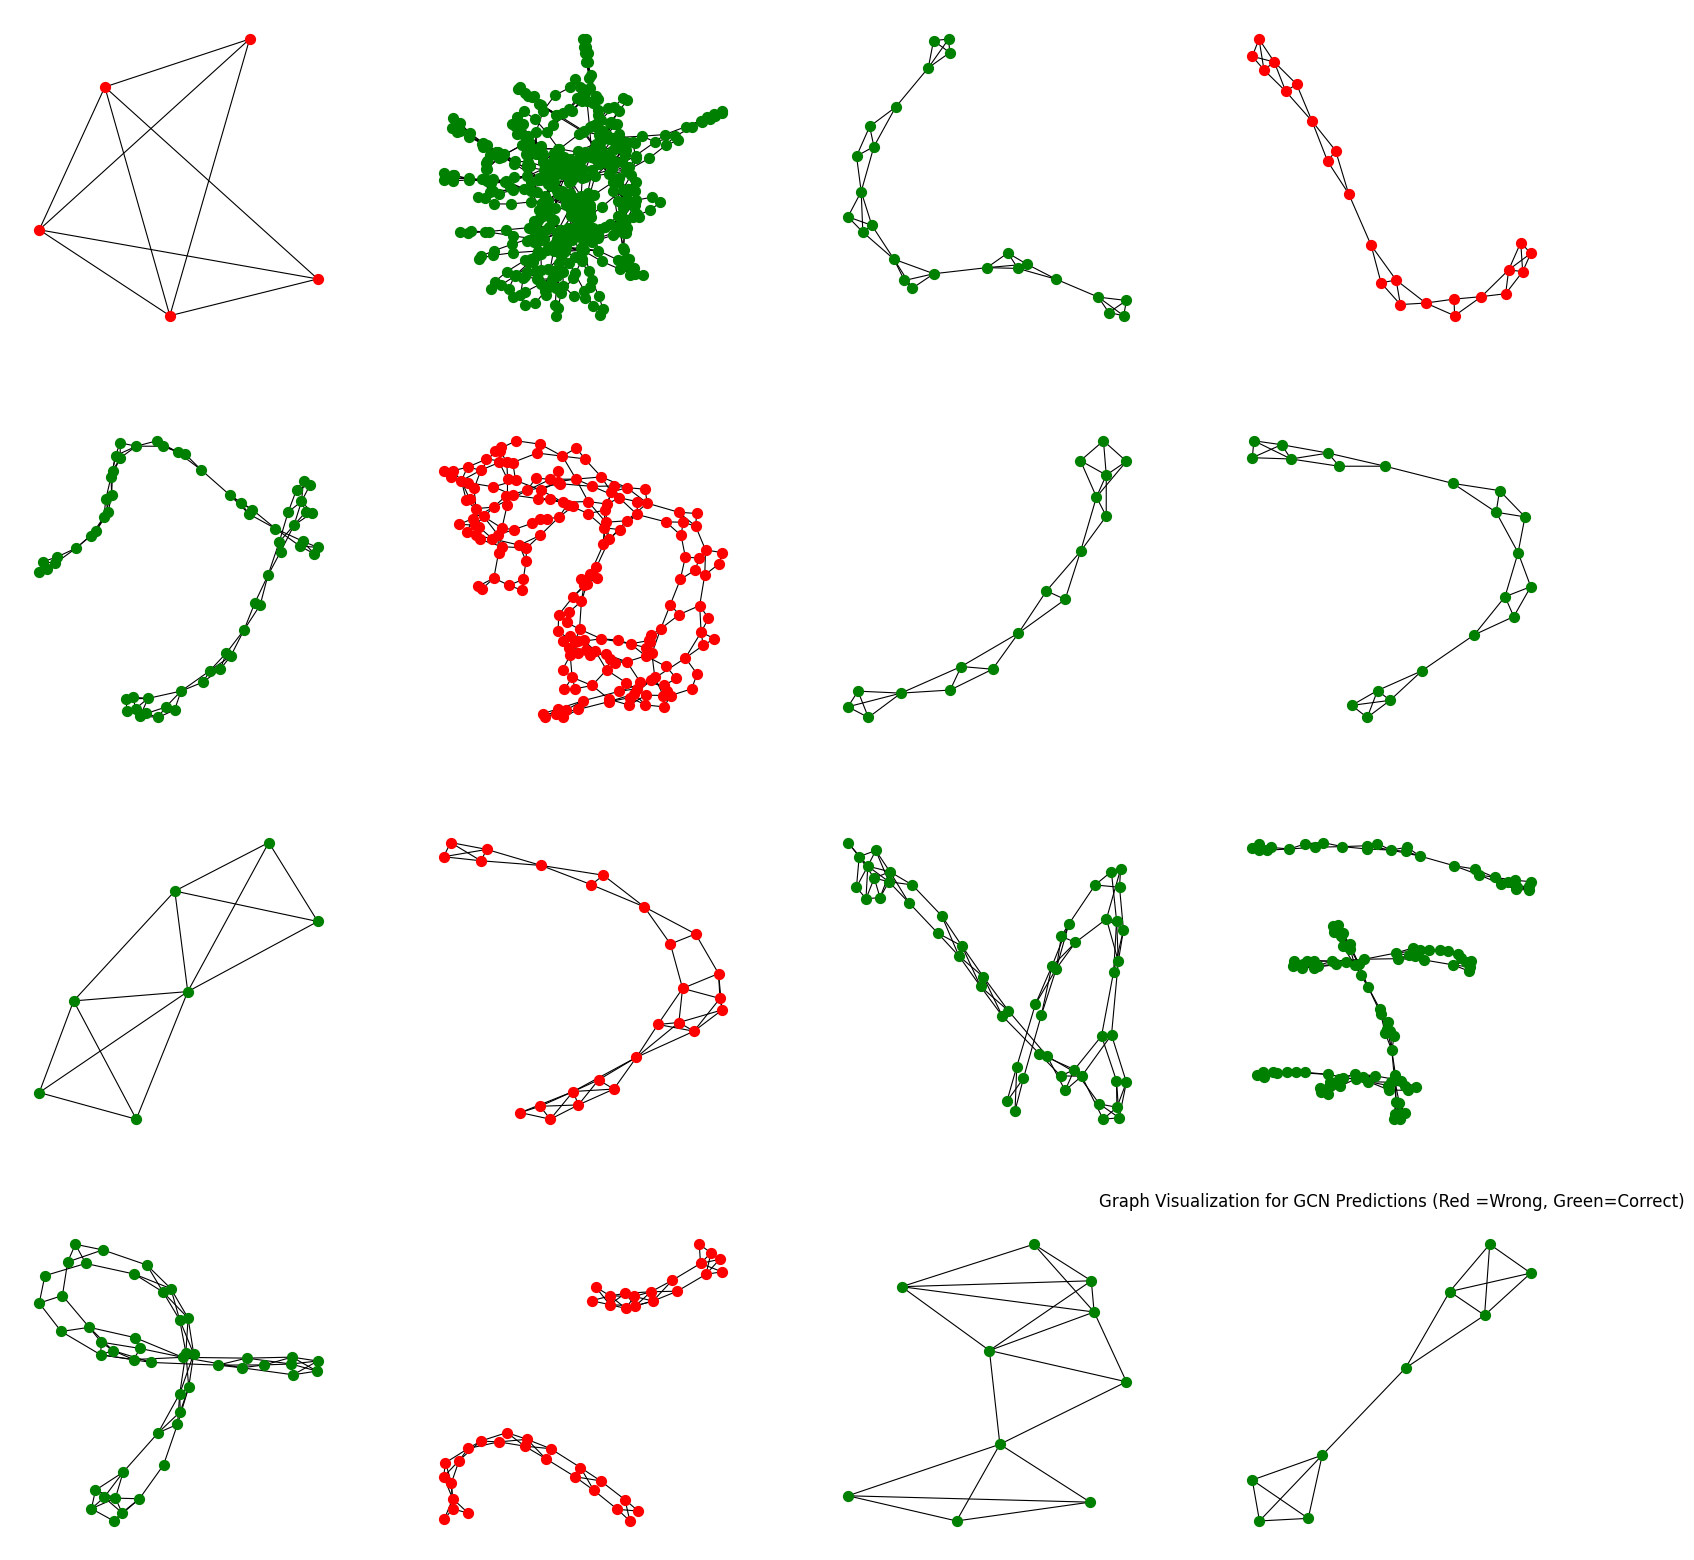

In [40]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
plt.title('Graph Visualization for GCN Predictions (Red =Wrong, Green=Correct)')
for i, data in enumerate(tu_data[-16:]):
    data = data.to(device)
    out = gcn(data.x, data.edge_index, data.batch)
    color = 'green' if out.argmax(dim=1) == data.y else 'red'
    ix = np.unravel_index(i, ax.shape)
    G = to_networkx(tu_data[i], to_undirected=True)
    nx.draw(G, ax=ax[ix], node_color=color, with_labels=False, pos =nx.spring_layout(G, seed = 0), node_size=50, width=0.8)
    

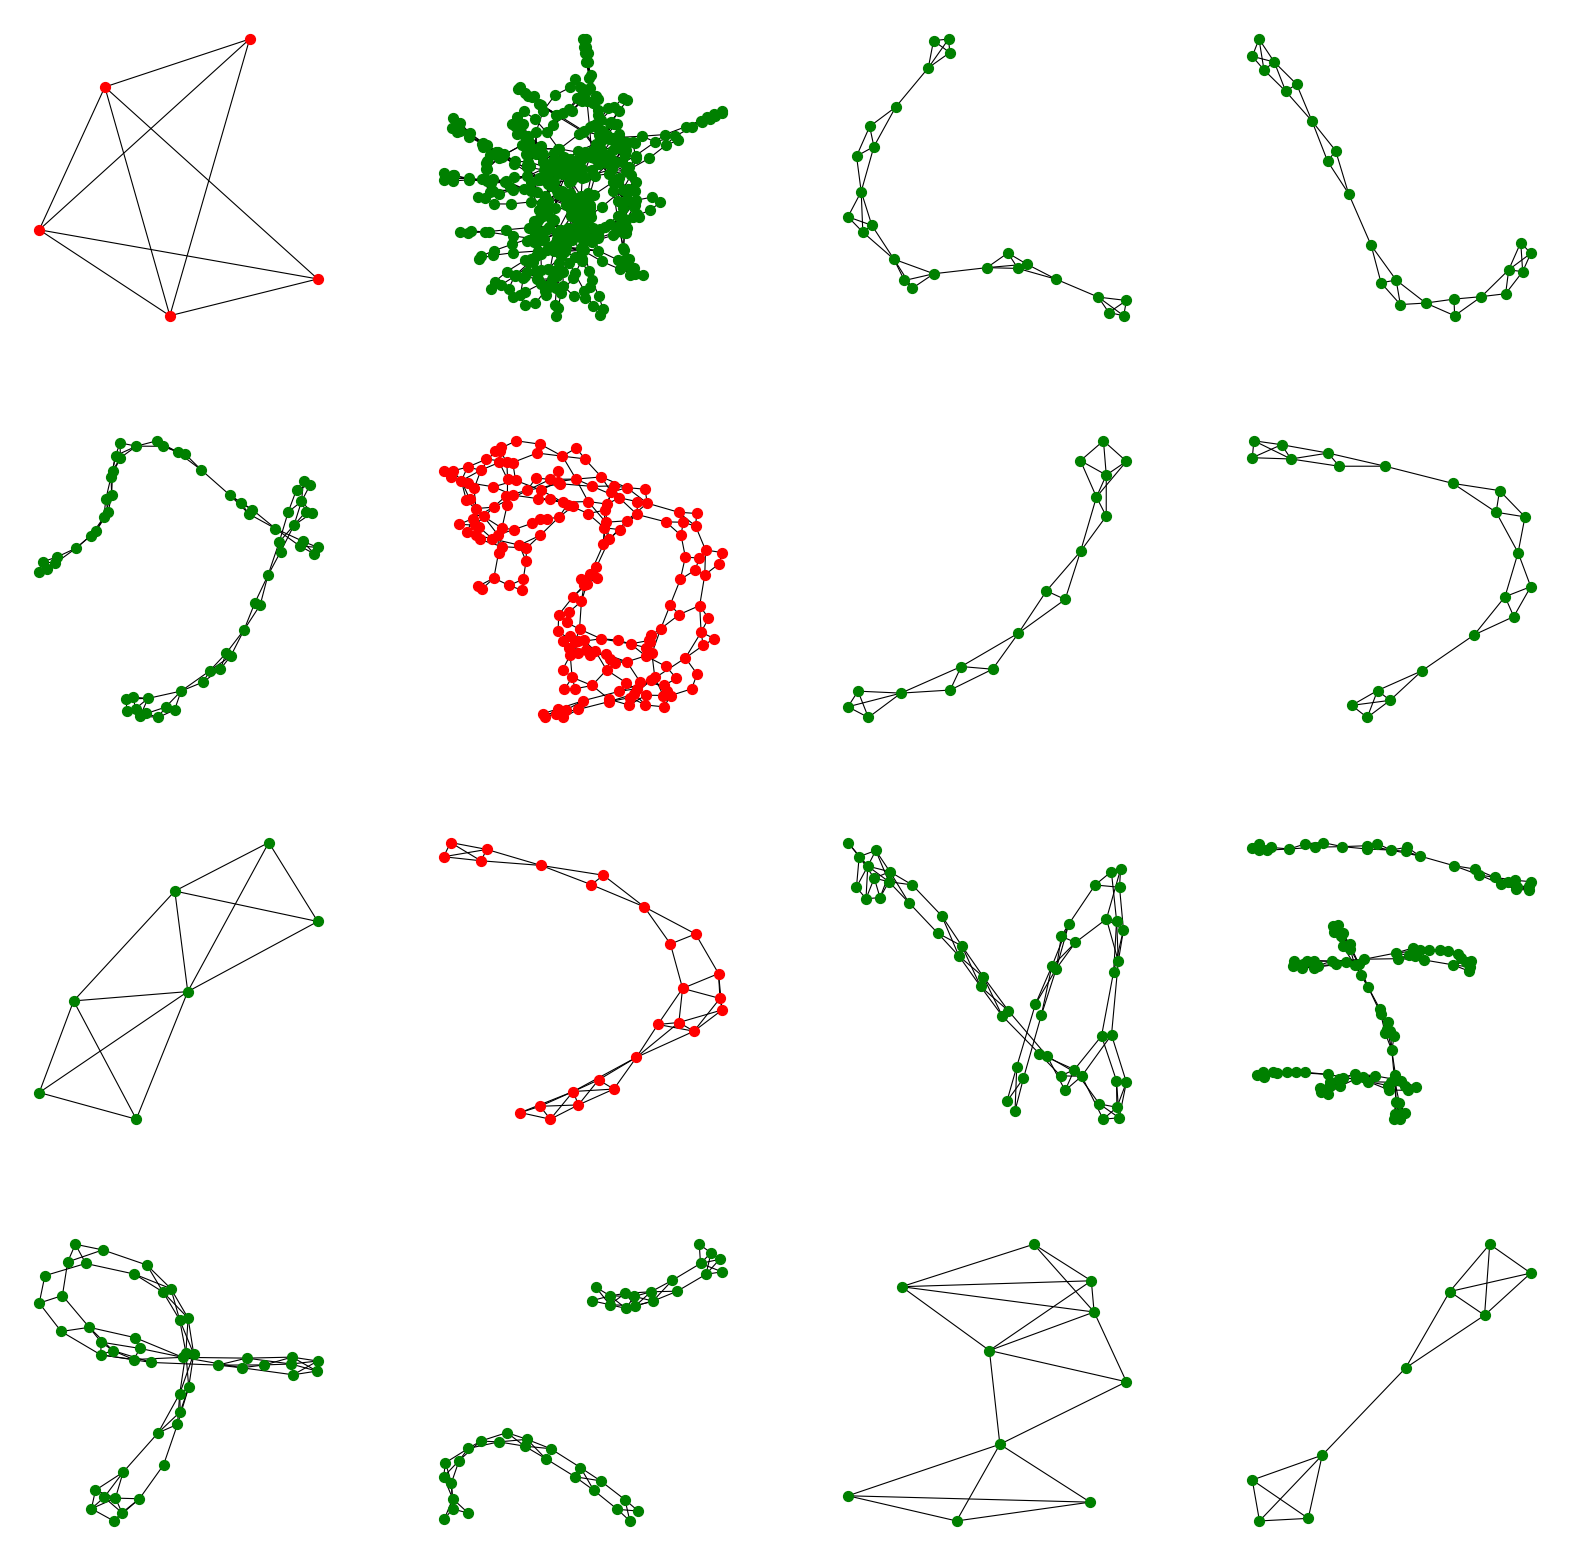

In [42]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, data in enumerate(tu_data[-16:]):
    data = data.to(device)
    out = gin(data.x, data.edge_index, data.batch)
    color = 'green' if out.argmax(dim=1) == data.y else 'red'
    ix = np.unravel_index(i, ax.shape)
    G = to_networkx(tu_data[i], to_undirected=True)
    nx.draw(G, ax=ax[ix], node_color=color, with_labels=False, pos =nx.spring_layout(G, seed = 0), node_size=50, width=0.8)